# Video Grep with CLIP-as-service

The notebook will show you how to use Jina AI and CLIP-as-service to search through videos for content specified by a natural language query.




---


First, we need to install some software.

We use [ffmpeg](https://ffmpeg.org/) to manage MP4 video data:

In [ ]:
!apt-get install ffmpeg


Verify that ffmpeg installed correctly.  This command should produce output that looks roughly like this:



```
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzmq --enable-libzvbi --enable-omx --enable-openal --enable-opengl --enable-sdl2 --enable-libdc1394 --enable-libdrm --enable-libiec61883 --enable-chromaprint --enable-frei0r --enable-libopencv --enable-libx264 --enable-shared
  libavutil      55. 78.100 / 55. 78.100
  libavcodec     57.107.100 / 57.107.100
  libavformat    57. 83.100 / 57. 83.100
  libavdevice    57. 10.100 / 57. 10.100
  libavfilter     6.107.100 /  6.107.100
  libavresample   3.  7.  0 /  3.  7.  0
  libswscale      4.  8.100 /  4.  8.100
  libswresample   2.  9.100 /  2.  9.100
  libpostproc    54.  7.100 / 54.  7.100
Hyper fast Audio and Video encoder
usage: ffmpeg [options] [[infile options] -i infile]... {[outfile options] outfile}...

Use -h to get full help or, even better, run 'man ffmpeg'
```



In [ ]:
!ffmpeg

Now we are going to install some standard Python libraries for video:

In [ ]:
pip install sk-video==1.1.10 Pillow ImageHash==4.2.1

And from Jina AI, we will install the DocArray library and the CLIP-as-service client.

**⚠️ Colab may show you a button to restart the runtime after this command. If so, DO PRESS THE BUTTON and and let the runtime restart before continuing.**

In [ ]:
pip install clip_client==0.8.1 docarray

Next, you will need a Jina authorization code for CL.  First, log in to Jina AI. If you do not have an account, follow the instructions on screen to create one.

In [ ]:
!jina auth login

Then, create a token for access to CLIP-as-service. The command below will create one called `video_search`. You can deactivate this token from [your token settings page at Jina AI Cloud](https://cloud.jina.ai/settings/tokens).

In [ ]:
!jina auth token create video_search

You should get a token in the form of a long hexadecimal number that should looks something like this: `54f0f0ef5d514ca1908698fc6d9555a5`

Copy the number into the command below and run it.

In [3]:
jina_auth_token = "<insert your token here>"

We will now set up a few functions for processing MP4 videos:

`keyframe_path` is the directory where we will store keyframes as JPEG images.

`upload_file()` Allows you to choose a file from your local file system to process. Make sure it is an MP4 video. If you choose more than one file, it will only take the first.

`download_file(url)` takes a URL and downloads the file from there. Make sure it is an MP4 video.

`get_keyframes_data(video_data, cut_sim=0.6)` extracts and saves keyframes from the video to the directory `keyframe_path`. The argument `cut_sim` is the sensitivity of the keyframe extraction: Lower values produce more keyframes and shorter matching segments, higher values produce fewer keyframes and longer matching segments, but are more likely to miss things if they are not on the screen very long. It defaults to 0.6.

`search_frame(keyframe_data, search_string, topn, token, server_url: str='grpcs://api.clip.jina.ai:2096')` takes the keyframes returned by `get_keyframes_data` and text to match (`search_string`) and returns at most
`topn` matching keyframes. `token` is the C-a-s authorization token already stored in `jina_auth_token`. It stores the results in the directory `tmp_video`.

`display_matching_videos()` displays the matching segments of video, centered on the keyframe matches, stored in `tmp_video`.


In [4]:
from docarray import Document, DocumentArray
from clip_client import Client
from google.colab import files
from urllib.parse import urlparse
from urllib.request import urlretrieve
from IPython.display import display, HTML
from PIL import Image
from base64 import b64encode
import numpy as np
import os
import skvideo.io
import warnings 
import shutil
import requests 
import imagehash

keyframe_path = 'keyframes'
if not os.path.exists(keyframe_path):
    os.mkdir(keyframe_path)


def _make_html_data_display(data, filename: str):
      data_url = "data:video/mp4;base64," + b64encode(data).decode()
      retstr = "<b>Filename:</b> " + filename + "<p>"
      retstr += """
              <video width=400 controls>
                    <source src="%s" type="video/mp4">
              </video>
              """ % data_url
      display(HTML(retstr))


def upload_video():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    display(HTML("Select an <b>MP4 video</b> file to upload.<br>"))
    uploaded_data = files.upload()
    for filename in uploaded_data.keys():
        uploaded_file_data = uploaded_data[filename]
        _make_html_data_display(uploaded_file_data, filename)
        return skvideo.io.vread(list(uploaded_data)[0])


def download_video_from_url(url: str):
    filename = os.path.basename(urlparse(url).path)
    urlretrieve(url, filename)
    _make_html_data_display(open(filename, 'rb').read(), filename)
    return skvideo.io.vread(filename)


def get_keyframes_data(video_data: 'np.ndarray', cut_sim: float=0.6):
    """
    This function extracts key frames from the video and save them into ``keyframes`` folder 
    """
    last_hash = imagehash.phash(Image.fromarray(video_data[0]))
    key_frames = [0]
    frame_num = 0
    for each_frame in video_data:
        frame_hash = imagehash.phash(Image.fromarray(each_frame))
        similarity = 1 - (last_hash - frame_hash) / len(frame_hash.hash) ** 2
        if similarity < cut_sim:
            key_frames.append(frame_num)
        frame_num += 1
        last_hash = frame_hash
    video_length = len(video_data)
    key_frames.append(video_length)
    keyframes_data = [((i, key_frames[key_frames.index(i)+1]), video_data[i]) for i in key_frames if i != video_length]
    
    if os.path.exists(keyframe_path):
        os.system('cd {} && rm *'.format(keyframe_path))
    for i, keyframe in enumerate(keyframes_data):
        Image.fromarray(keyframe[1]).save(f"{keyframe_path}/{i}.jpeg")

    return DocumentArray([
        Document(tags={'left': str(tup[0][0]),'right': str(tup[0][1])},
                 tensor=tup[1]).convert_image_tensor_to_blob()
                 for tup in keyframes_data])


def search_frame(keyframe_da: DocumentArray, prompt: str, topn: int, token: str, server_url: str='grpcs://api.clip.jina.ai:2096'):
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    client = Client(server_url, credential={'Authorization': token})
    d = Document(text=prompt, matches=keyframe_da)
    r = client.rank([d], show_progress=True)
    result = r['@m', ['tags', 'blob', 'scores__clip_score__value']]
    spams, ndarray, scores = [each[:topn] for each in result]
    if os.path.exists('tmp_videos'):
        for video in os.listdir('tmp_videos'):
            os.remove(os.path.join('tmp_videos', video))
        shutil.rmtree('tmp_videos')
    for spam in spams:
        i = spams.index(spam)
        os.makedirs('tmp_videos', exist_ok=True)
        save_name = 'tmp_videos/' + str(i) + '_tmp.mp4'
        skvideo.io.vwrite(save_name, video_data[int(spam['left']):int(spam['right'])])


def display_matching_videos():
    """
    NOTICE: this function is not working in for loop,
    so run it multiple times if you want to display multiple videos
    """
    fn_list = []
    for fn in os.listdir('tmp_videos'):
        if fn.endswith('.mp4'):
            fn_list.append(fn)
    
    retstr = ''
    for fn in sorted(fn_list):
        mp4 = open('tmp_videos/' + fn, 'rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        nbr = int(fn[0]) + 1
        retstr += "<b>Match #" + str(nbr) + "</b><p>"
        retstr += """
                <video width=400 controls>
                      <source src="%s" type="video/mp4">
                </video><br>
                """ % data_url
    return HTML(retstr)

Now, you can choose to upload a video of your own, or use an example video from the Internet.

__⚠️ Please keep the size under 15MB or you risk overflowing the notebook's memory.__

If you run the command below, it will download the trailer to the 1964 film "[Santa Claus Conquers the Martians](https://archive.org/details/santa-clause-conquers-the-martians)" from the Internet Archive.

Alternately, substitute your own URL to an MP4 video.

In [ ]:
video_data = download_video_from_url("https://archive.org/download/santa-clause-conquers-the-martians/Santa%20Clause%20Conquers%20The%20Martians.ia.mp4")

Or, you can upload an MP4 video from local files on your computer by running the command below and clicking in the "Upload" button to choose a file.

In [ ]:
video_data = upload_video()

Now that we have an MP4 video, we will extract keyframes. The optional argument cut_sim determines how much an image needs to change before it's considered a different keyframe. Lower values lead to more keyframes, higher values lead to fewer. The default is 0.6.

In [8]:
keyframe_data = get_keyframes_data(video_data, cut_sim=0.6)

And now, we will use Jina AI and CLIP-as-service to search the keyframes for ones that match the string query. If you downloaded "Santa Claus Conquers the Martians", the query "Santa Claus" will find keyframes containing Santa. For example:

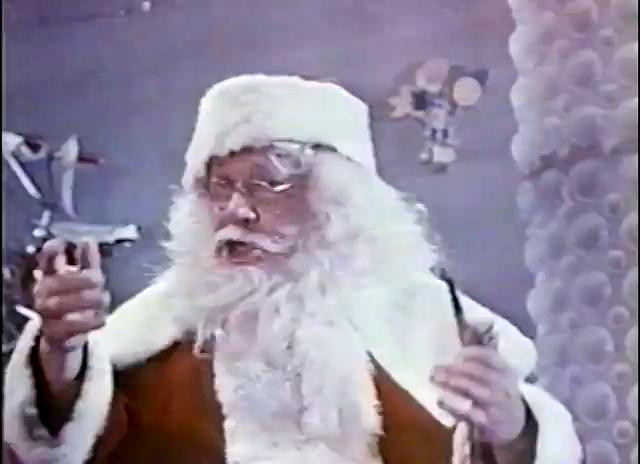

For other videos, you should choose an appropriate text to search.

The argument "5" is the maximum number of matches to return. If you use this, you can expect to get no more than five matching segments. There may be more matches. You can set this to any positive number you like, but higher numbers will require more processing time.



In [ ]:
search_string = 'Santa Claus'
search_frame(keyframe_data, search_string, 5, jina_auth_token)

Lastly, display the video segments associated with each matched keyframe.


In [ ]:
display_matching_videos()